In [11]:
import bluefog.torch as bf
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch

%matplotlib inline

In [12]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")
rc.ids

[0, 1, 2, 3]

In [13]:
%%px
import torch
import bluefog.torch as bf
from bluefog.common import topology_util
bf.init()

print(f"Rank: {bf.rank()}, Size: {bf.size()}")

[stdout:0] Rank: 2, Size: 4
[stdout:1] Rank: 3, Size: 4
[stdout:2] Rank: 1, Size: 4
[stdout:3] Rank: 0, Size: 4


# Gradient Tracking Algorithm

Last, we introduce another type of decentralized optimization algorithm. It is similar as EXTRA. It will not produce the average consensus bias for general topology and cost function setting. Moreover, it works with the dynamic topology case pretty well. In constrast, the EXTRA type algorithm may divergence under general dynamic topology setting. The stacked version of gradient tracking algorithm is listed as follows:

\begin{align}
    x_{k+1} &\;= W^{(k)}\left(x_k - \alpha y_k\right)\\
    y_{k+1} &\;= W^{(k)}\left(y_k + \nabla f(x_{k+1}) - \nabla f(x_k)\right)
\end{align}

where $W^{(k)}$ is column stochastic matrix.
It has similar AWT versions if you apply $W^{(k)}$ on $w_k$ or $q_k$ only. 

For directed networks, Push-DIGing algorithm needs to further correct the consensus bias:
\begin{align}
    u_{k+1} &\;= W^{(k)}\left(u_k - \alpha y_k\right)\\
    v_{k+1} &\;= W^{(k)} v_{k}  \\
    x_{k+1} &\;= u_{k+1} / v_{k+1}\\
    y_{k+1} &\;= W^{(k)}\left(y_k + \nabla f(x_{k+1}) - \nabla f(x_k)\right)
\end{align}
Here we used $v_{k}$, which is just the previous correction weights $p$.

In [14]:
%%px

def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

As we did in chapter 3, we generate the local data and use distributed gradient descent as reference point for correctness check.

In [15]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In [ ]:
%%px

m, n = 20, 5
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=500, alpha=1e-2)

In [17]:
%%px 

def Gradient_tracking_one_step(x, y, u, v, prev_grad_local, dynamic_neighbor_gen,
                               x_opt, A, b, alpha=1e-2):
    # Get the update weights
    dst_neighbors, src_neighbors = next(dynamic_neighbor_gen)
    src_weights = {r: 1 for r in src_neighbors}
    self_weight = 1 / (len(dst_neighbors) + 1)
    dst_weights = {r: self_weight for r in dst_neighbors}
    
    # u update step: u_{k+1} = W^k (u_k - \alpha*y_k)
    w = u - alpha*y
    u_new = bf.neighbor_allreduce(
        w,  self_weight=self_weight,
        src_weights=src_weights,
        dst_weights=dst_weights, enable_topo_check=True)
    # v update:  v_{k+1} = W^k v_{k}  ---   (Correction weights)
    v_new = bf.neighbor_allreduce(
        v,  self_weight=self_weight,
        src_weights=src_weights,
        dst_weights=dst_weights, enable_topo_check=True)
    # x update: x_{k+1} = u_{k+1} / v_{k+1} (element-wise division)
    x_new = u_new / v_new
    # y update step: y_{k+1} = W^k (y_k + \grad f(x_{k+1}) - \grad f(x_{k}))
    grad_local = A.t().mm(A.mm(x_new) - b)
    q = y + grad_local - prev_grad_local
    y_new = bf.neighbor_allreduce(
        q,  self_weight=self_weight,
        src_weights=src_weights,
        dst_weights=dst_weights, enable_topo_check=True)
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, y_new, u_new, v_new, grad_local, rel_error

In [24]:
%%px

bf.set_topology(topology_util.MeshGrid2DGraph(bf.size()))
dynamic_neighbor_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank())

maxite = 250
x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
u = x.clone()
y = x.clone()
prev_grad_local = x.clone()
v = torch.ones(n, 1, dtype=torch.double)      # Initialize v as all one vector

rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, y, u, v, prev_grad_local, rel_error[ite] = Gradient_tracking_one_step(
        x, y, u, v, prev_grad_local,
        dynamic_neighbor_gen, x_opt, A, b, alpha=1e-2) # you can adjust alpha to different values

[stdout:3] 
Progress 0/250
Progress 10/250
Progress 20/250
Progress 30/250
Progress 40/250
Progress 50/250
Progress 60/250
Progress 70/250
Progress 80/250
Progress 90/250
Progress 100/250
Progress 110/250
Progress 120/250
Progress 130/250
Progress 140/250
Progress 150/250
Progress 160/250
Progress 170/250
Progress 180/250
Progress 190/250
Progress 200/250
Progress 210/250
Progress 220/250
Progress 230/250
Progress 240/250


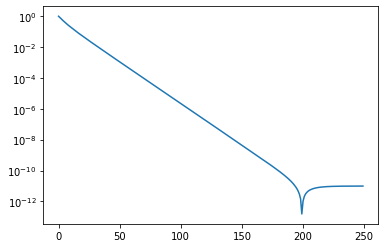

In [25]:
plt.semilogy(rc[0]['rel_error'])